# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---

## Step 1: Dataset Exploration

Visualize the German Traffic Signs Dataset. This is open ended, some suggestions include: plotting traffic signs images, plotting the count of each sign, etc. Be creative!


The pickled data is a dictionary with 4 key/value pairs:

- features -> the images pixel values, (width, height, channels)
- labels -> the label of the traffic sign
- sizes -> the original width and height of the image, (width, height)
- coords -> coordinates of a bounding box around the sign in the image, (x1, y1, x2, y2). Based the original image (not the resized version).

11


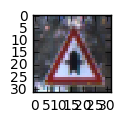

In [1]:
# Load pickled data
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
import socket
import random
%matplotlib inline

# TODO: fill this in based on where you saved the training and testing data
computer_name = socket.gethostname()
if "Air" in computer_name:
    training_file = "/Users/Sheep/Library/git/traffic-signs/traffic-signs-data/train.p"
    testing_file = "/Users/Sheep/Library/git/traffic-signs/traffic-signs-data/test.p"
elif "T540p" in computer_name:
    training_file = "/home/yy/git/traffic-signs/traffic-signs-data/train.p"
    testing_file = "/home/yy/git/traffic-signs/traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train_full, y_train_full = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

index = random.randint(0, len(X_train_full))
image = X_train_full[index].squeeze()

plt.figure(figsize=(1,1))
print(y_train_full[index])
plt.imshow(image, interpolation='nearest')
plt.show()

In [2]:
### To start off let's do a basic data summary.

# TODO: number of training examples
n_train = len(X_train_full)

# TODO: number of testing examples
n_test = len(X_test)

# TODO: what's the shape of an image?
image_shape = X_train_full[0].shape

# TODO: how many classes are in the dataset
n_classes = max(y_train_full) + 1

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


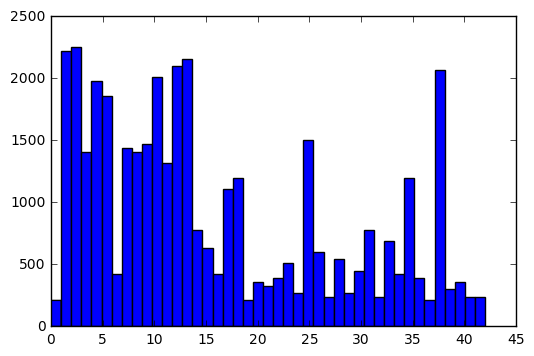

In [3]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Plot the distribution of the labels
plt.hist(y_train_full, bins = n_classes);
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Your model can be derived from a deep feedforward net or a deep convolutional network.
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

# Normalize the data
def normalize_grayscale(image_data):
    """
    Normalize the image data with Min-Max scaling to a range of [0.1, 0.9]
    :param image_data: The image data to be normalized
    :return: Normalized image data
    """
    a = -0.5
    b = 0.5
    grayscale_min = 0
    grayscale_max = 255
    return a + ( ( (image_data - grayscale_min)*(b - a) )/( grayscale_max - grayscale_min ) )

X_normalized = normalize_grayscale(X_train_full)

# Create seperate validation data set from full training data set
from sklearn.model_selection import train_test_split
X_train, X_validation, y_train, y_validation = train_test_split(X_normalized, y_train_full, test_size=0.15, random_state=42)

# Shuffle the train and validation data set
from sklearn.utils import shuffle
X_train, y_train = shuffle(X_train, y_train)
X_validation, y_validation = shuffle(X_validation, y_validation)

# Summary on the new train and validation data set
n_train = len(X_train)
n_validation = len(X_validation)
print("Number of final training examples =", n_train)
print("Number of validation examples =", n_validation)

Number of final training examples = 33327
Number of validation examples = 5882


### Question 1 

_Describe the techniques used to preprocess the data._

**Answer:**
1: Shuffle the training data and validation data.
2: Another very important method is to normalize the data so that the model will be much easier to train. With original picture data each pixel will be 0 to 255, this is much harder for models to converge.


In [5]:
### Generate data additional (if you want to!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

# Train/validation separation was done in previous block

### Question 2

_Describe how you set up the training, validation and testing data for your model. If you generated additional data, why?_

**Answer:**
1: Split the training data using sklearn train_test_split function to create validation data.


In [6]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [7]:
# Set up Tensorflow
import tensorflow as tf

EPOCHS = 20
BATCH_SIZE = 128

In [8]:
# LeNet function
from tensorflow.contrib.layers import flatten
keep_prob = tf.placeholder(tf.float32) # probability to keep units

def conv2d(x, W, b, strides=1):
    # Conv2D wrapper, with bias and relu activation
    x = tf.nn.conv2d(x, W, strides=[1, strides, strides, 1], padding='VALID')
    x = tf.nn.bias_add(x, b)
    return tf.nn.relu(x)


def maxpool2d(x, k=2):
    # MaxPool2D wrapper
    return tf.nn.max_pool(x, ksize=[1, k, k, 1], strides=[1, k, k, 1],
                          padding='VALID')

def LeNet(x):
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Store layers weight & bias
    weights = {
        # 5x5 conv, 1 input, 6 outputs
        'wc1': tf.Variable(tf.random_normal([5, 5, 3, 6], mean = mu, stddev = sigma)),
        # 5x5 conv, 6 inputs, 16 outputs
        'wc2': tf.Variable(tf.random_normal([5, 5, 6, 16], mean = mu, stddev = sigma)),
        # fully connected, 400 inputs, 120 outputs
        'wd3': tf.Variable(tf.random_normal([400, 120], mean = mu, stddev = sigma)),
        # 120 inputs, 84 outputs (class prediction)
        'wd4': tf.Variable(tf.random_normal([120, 84], mean = mu, stddev = sigma)),
        # 84 inputs, 43 outputs (class prediction)
        'out': tf.Variable(tf.random_normal([84, 43], mean = mu, stddev = sigma))
    }

    biases = {
        'bc1': tf.Variable(tf.zeros([6])),
        'bc2': tf.Variable(tf.zeros([16])),
        'bd3': tf.Variable(tf.zeros([120])),
        'bd4': tf.Variable(tf.zeros([84])),
        'out': tf.Variable(tf.zeros([43]))
    }

    # TODO: Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    # TODO: Activation.
    conv1 = conv2d(x, weights['wc1'], biases['bc1'])

    # TODO: Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = maxpool2d(conv1, k=2)
    
    # Add a dropout layer here
    dropout_layer = tf.nn.dropout(conv1, keep_prob)
    
    # TODO: Layer 2: Convolutional. Output = 10x10x16.
    # TODO: Activation.
    conv2 = conv2d(conv1, weights['wc2'], biases['bc2'])

    # TODO: Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = maxpool2d(conv2, k=2)
    
    # TODO: Flatten. Input = 5x5x16. Output = 400.
    fc = flatten(conv2)
    
    # TODO: Layer 3: Fully Connected. Input = 400. Output = 120.
    fc3 = tf.add(tf.matmul(fc, weights['wd3']), biases['bd3'])
    
    # TODO: Activation.
    fc3 = tf.nn.relu(fc3)

    # TODO: Layer 4: Fully Connected. Input = 120. Output = 84.
    fc4 = tf.add(tf.matmul(fc3, weights['wd4']), biases['bd4'])
    
    # TODO: Activation.
    fc4 = tf.nn.relu(fc4)
    
    # TODO: Layer 5: Fully Connected. Input = 84. Output = 43.
    logits = tf.add(tf.matmul(fc4, weights['out']), biases['out'])

    return logits

In [9]:
# Features and Labels
x = tf.placeholder(tf.float32, (None, 32, 32, 3))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, 43)

In [10]:
# Training pipeline
rate = 0.0005

logits = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [11]:
# Model evaluation
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:**
1: The base model is LeNet. It has two convolutional layers and three fully connected layters. The layer details are:
5x5 conv, 1 input, 6 outputs
5x5 conv, 6 inputs, 16 outputs
fully connected, 400 inputs, 120 outputs
120 inputs, 84 outputs
84 inputs, 43 outputs (class prediction)
I used RELU as the activation function.
2: Add a dropout layer between the two convolutional layers to prevent overfitting.

In [12]:
### Train your model here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.5})
            
        validation_accuracy = evaluate(X_validation, y_validation)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
        
    saver.save(sess, 'lenet')
    print("Model saved")

Training...

EPOCH 1 ...
Validation Accuracy = 0.628

EPOCH 2 ...
Validation Accuracy = 0.812

EPOCH 3 ...
Validation Accuracy = 0.869

EPOCH 4 ...
Validation Accuracy = 0.916

EPOCH 5 ...
Validation Accuracy = 0.928

EPOCH 6 ...
Validation Accuracy = 0.935

EPOCH 7 ...
Validation Accuracy = 0.951

EPOCH 8 ...
Validation Accuracy = 0.960

EPOCH 9 ...
Validation Accuracy = 0.961

EPOCH 10 ...
Validation Accuracy = 0.965

EPOCH 11 ...
Validation Accuracy = 0.963

EPOCH 12 ...
Validation Accuracy = 0.972

EPOCH 13 ...
Validation Accuracy = 0.968

EPOCH 14 ...
Validation Accuracy = 0.973

EPOCH 15 ...
Validation Accuracy = 0.977

EPOCH 16 ...
Validation Accuracy = 0.977

EPOCH 17 ...
Validation Accuracy = 0.980

EPOCH 18 ...
Validation Accuracy = 0.978

EPOCH 19 ...
Validation Accuracy = 0.978

EPOCH 20 ...
Validation Accuracy = 0.982

Model saved


Warning!
Don't run below testing code until the model is ready!

In [13]:
# Evaluate the model with test data set
X_test_normalized = normalize_grayscale(X_test)

with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test_normalized, y_test)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.903


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:**
1: We used AdamOptimizer, batch size is 128, epochs is 20. Hyperparameters are mainly the mean and stdev of the truncated normal distribution of the weights.

### Question 5


_What approach did you take in coming up with a solution to this problem?_

**Answer:**
1: I started from the LeNet lab and change the inter-layer parameters according to the traffic sign data.
2: I tried to change the epoches together with the learning rate, it seems with smaller learning rate, the final validation accuracy can be higher, but it also needs more epoches. At last I chose 0.005 learning rate and 20 epoches.
3: To prevent overfitting with the low learning rate, I tried dropout methed and it indeed gave better results.

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

Image data shape = (32, 32, 3)
Image data shape = (32, 32, 3)
Image data shape = (32, 32, 3)
Image data shape = (32, 32, 3)
Image data shape = (32, 32, 3)


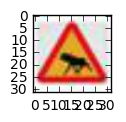

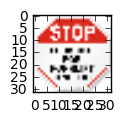

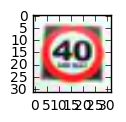

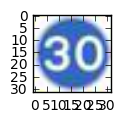

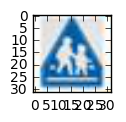

In [14]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

import os
from PIL import Image

# maxsize = (32, 32)
# os.listdir("test_images/")
# images = os.listdir("test_images/")
# for image_name in images:
#     image = Image.open('test_images/' + image_name)
#     image.thumbnail(maxsize, Image.ANTIALIAS)
#     image.save('test_images/' + 'thumb_' + image_name)
    
os.listdir("test_images/")
images = os.listdir("test_images/")
for image_name in images:
    image = mpimg.imread('test_images/' + image_name)
    plt.figure(figsize=(1,1))
    plt.imshow(image)
    image_shape = image.shape
    print("Image data shape =", image_shape)


### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It would be helpful to plot the images in the notebook._



**Answer:**
1: The five images I chose are all non-standard traffic signs, it's interesting to see how the model interpret the non-standard traffic signs.

In [15]:
### Run the predictions here.
### Feel free to use as many code cells as needed.

for image_name in images:
    image = mpimg.imread('test_images/' + image_name)
    # image = mpimg.imread('test_images/' + 'thumb_animal.jpg')
    image_normalized = normalize_grayscale(image)
    reshaped = np.expand_dims(image_normalized, axis=0)
    # reshaped = tf.reshape(image, [-1, 32, 32, 3])
    # tf.constant(image, tf.float32, (3, 32, 32, 3))
    soft_max = tf.nn.softmax(logits)
    labels_predicted = tf.argmax(soft_max, 1)
    # top3_pred = sess.run(tf.nn.top_k(tf.constant(soft_max), k=3))

    with tf.Session() as sess:
        loader = tf.train.import_meta_graph('lenet.meta')
        loader.restore(sess, tf.train.latest_checkpoint('./'))
        
        print(image_name)
        print(sess.run(labels_predicted, feed_dict={x: reshaped}))
        # print(sess.run(top3_pred, feed_dict={x: reshaped}))
        # print(sess.run(tf.nn.top_k(tf.constant(soft_max), k=3)))
    

thumb_animal.jpg
[23]
thumb_special_stop.png
[9]
thumb_speed_40.jpg
[1]
thumb_blue_speed_30.jpg
[39]
thumb_children_crossing.jpg
[18]


### Question 7

_Is your model able to perform equally well on captured pictures or a live camera stream when compared to testing on the dataset?_


**Answer:**
1: With non-standard signs, the model actually performed poorly, none of the 5 predictions are correct.

In [16]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.

for image_name in images:
    image = mpimg.imread('test_images/' + image_name)
    # image = mpimg.imread('test_images/' + 'thumb_animal.jpg')
    reshaped = np.expand_dims(image, axis=0)
    # reshaped = tf.reshape(image, [-1, 32, 32, 3])
    # tf.constant(image, tf.float32, (3, 32, 32, 3))
    soft_max = tf.nn.softmax(logits)
    labels_predicted = tf.argmax(soft_max, 1)
    # top3_pred = sess.run(tf.nn.top_k(tf.constant(soft_max), k=3))

    with tf.Session() as sess:
        loader = tf.train.import_meta_graph('lenet.meta')
        loader.restore(sess, tf.train.latest_checkpoint('./'))
        
        print(image_name)
        print(sess.run(soft_max, feed_dict={x: reshaped}))
        # print(sess.run(top3_pred, feed_dict={x: reshaped}))
        # print(sess.run(tf.nn.top_k(tf.constant(soft_max), k=3)))


thumb_animal.jpg
[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
   0.  0.  0.  0.  0.  0.  0.]]
thumb_special_stop.png
[[  2.86049602e-19   3.08748578e-13   8.80480409e-18   2.21712554e-19
    4.58476260e-29   6.49089899e-24   1.61653694e-11   1.74576117e-18
    9.92281312e-30   2.18121954e-20   1.96684015e-15   7.62926757e-01
    2.01536668e-03   1.23774375e-14   1.11332981e-23   2.48626266e-37
    6.22720359e-17   3.19831659e-19   9.08237261e-15   2.56293350e-16
    8.69749996e-08   1.61234998e-10   1.52446430e-18   1.20311017e-06
    2.65411107e-17   2.35023409e-01   1.29762940e-14   1.91373479e-17
    2.14097542e-11   1.10299010e-15   3.29349277e-05   1.06445386e-12
    2.07193729e-14   1.41061042e-16   1.00637075e-10   1.11136584e-14
    4.68700190e-10   5.05959918e-14   1.92738483e-16   2.81956883e-25
    2.52213738e-07   7.37278905e-10   9.97022256e-11]]
thumb_speed_40.jpg
[[ 0. 

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.11/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*


**Answer:**
1: The model results show certainty for 4 out of the 5 pictures. The possibility are all above 97%, 3 of them are actually very near 100%.
2: For special STOP sign, the model show uncertainty.

### Question 9
_If necessary, provide documentation for how an interface was built for your model to load and classify newly-acquired images._


**Answer:**
1: I downloaded five pictures from online and use Image from PIL to convert them to 32x32 format that the model will accept.
2: Then I run the five pictures through the model one by one.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.